In [26]:
import numpy as np
import matplotlib.pylab as plt

from qiskit import IBMQ, pulse
from qiskit.pulse import library
from qiskit.pulse.macros import measure

from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel
# from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter
from qiskit.compiler import assemble

In [20]:
# IBMQ.load_account()
# backend_real = IBMQ.providers()[0].backends(open_pulse=True)[0]
backend_sim = PulseSimulator()

# Mock Armonk backend
from qiskit.test.mock.backends.armonk.fake_armonk import FakeArmonk
armonk_backend = FakeArmonk()
# set the drive strength
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = 63455017.85

# set the qubit frequency
freq_est = 4.97e9
armonk_backend.defaults().qubit_freq_est = [freq_est]
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['wq0'] = 2*np.pi*freq_est
armonk_model = PulseSystemModel.from_backend(armonk_backend)

dt =  2.2222222222222221e-10


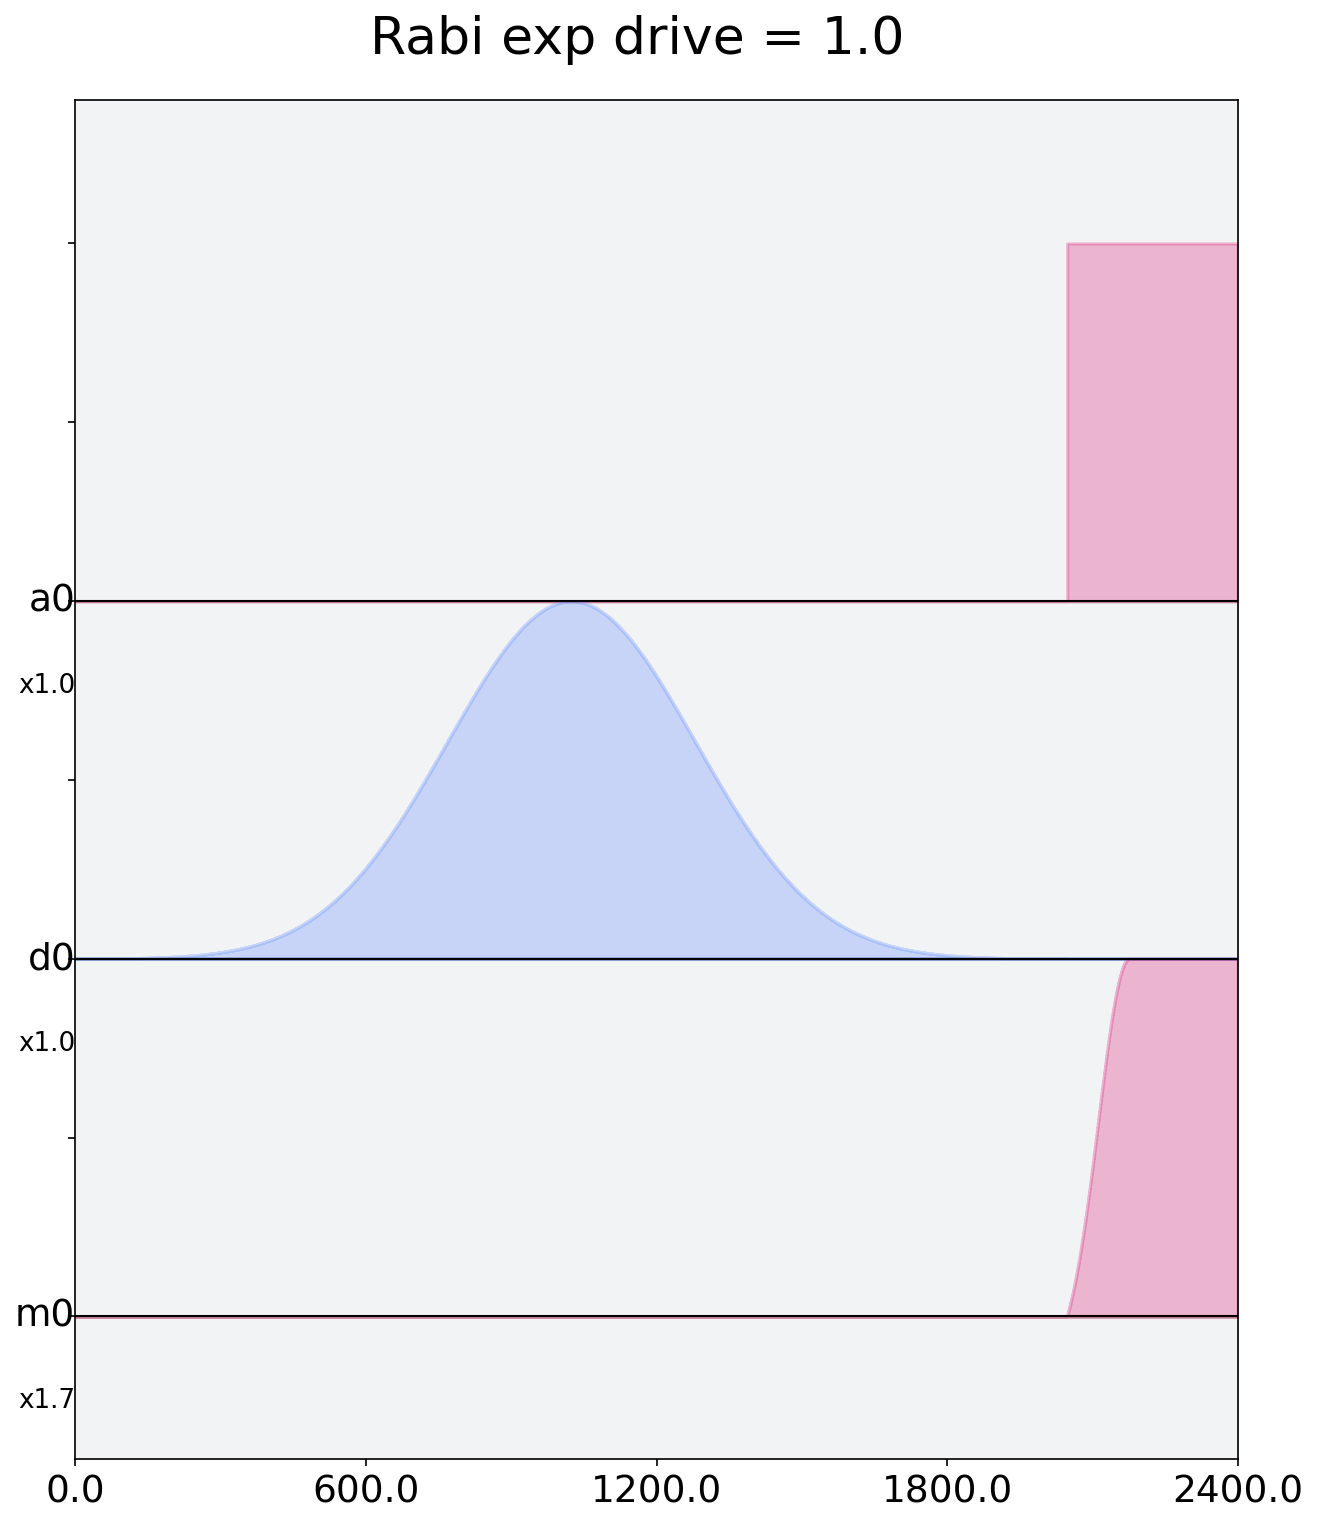

In [27]:
qubit = 0
duration = 2048
sigma = 256
num_points = 64
print('dt = ', armonk_backend.configuration().dt)
drive_amps = np.linspace(0, 1, num_points)

rabi_schedules = []
for amp in drive_amps:
    schd = pulse.Schedule(name='Rabi exp drive = {}'.format(amp))
    schd += pulse.Play(library., pulse.DriveChannel(qubit))
    schd += measure([qubit], armonk_backend) << schd.duration
    rabi_schedules.append(schd)

rabi_schedules[-1].draw(plot_range=[0, 2400])

In [29]:
rabi_qobj = assemble(rabi_schedules,
                     backend=backend_sim,
                     meas_level=1,
                     meas_return='avg',
                     shots=2048)
sim_result = backend_sim.run(rabi_qobj, armonk_model).result()

/home/pyserver/miniconda3/lib/python3.8/site-packages/qiskit/compiler/assemble.py:320: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  warnings.warn(
/home/pyserver/miniconda3/lib/python3.8/site-packages/qiskit/pulse/library/parametric_pulses.py:77: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  warnings.warn('`get_sample_pulse` has been deprecated. '
/home/pyserver/miniconda3/lib/python3.8/site-packages/qiskit/pulse/library/parametric_pulses.py:77: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  warnings.warn('`get_sample_pulse` has been deprecated. '
/home/pyserver/miniconda3/lib/python3.8/site-packages/qiskit/pulse/library/parametric_pulses.py:77: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  warnings.warn('`get_sample_pulse` has been deprecated. '
/home/pyserver/miniconda3/lib/python3.8/sit

In [31]:
result = sim_result
response = []
for i in range(len(drive_amps)):
    response.append(result.get_memory(i)[qubit])
response = response - np.mean(response)

/home/pyserver/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


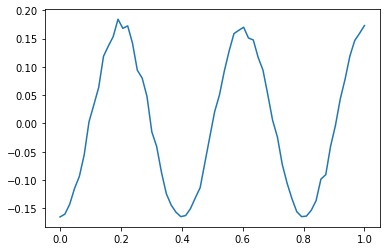

In [33]:
plt.figure(facecolor='w')
plt.plot(drive_amps, response)
